# AAPL Forecasting

### Import Import Libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('seaborn-v0_8-darkgrid')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
Warning = False

### Loading the dataset

In [80]:
csv_path = "AAPL.csv"

# Read the CSV, parse 'Date' column as Date, and set it as the index
df = pd.read_csv(
    csv_path,
    parse_dates=["Date"],
    dayfirst=False,
    index_col="Date"
)

# Sort the DataFrame by the Date index in ascending order
df.sort_index(inplace=True)

In [81]:
df.head()

Open   High    Low  Close  Adj Close       Volume
Date                                                          
2015-01-02  27.85  27.86  26.84  27.33      24.29  212,818,400
2015-01-05  27.07  27.16  26.35  26.56      23.60  257,142,000
2015-01-06  26.64  26.86  26.16  26.57      23.61  263,188,400
2015-01-07  26.80  27.05  26.67  26.94      23.94  160,423,600
2015-01-08  27.31  28.04  27.17  27.97      24.86  237,458,000

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2628 entries, 2015-01-02 to 2025-06-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2628 non-null   float64
 1   High       2628 non-null   float64
 2   Low        2628 non-null   float64
 3   Close      2628 non-null   float64
 4   Adj Close  2628 non-null   float64
 5   Volume     2628 non-null   object 
dtypes: float64(5), object(1)
memory usage: 143.7+ KB


### Plot the closing price

/var/folders/lq/v5x41nl16tb6fdhx8rdm3kfm0000gn/T/ipykernel_949/3965578024.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


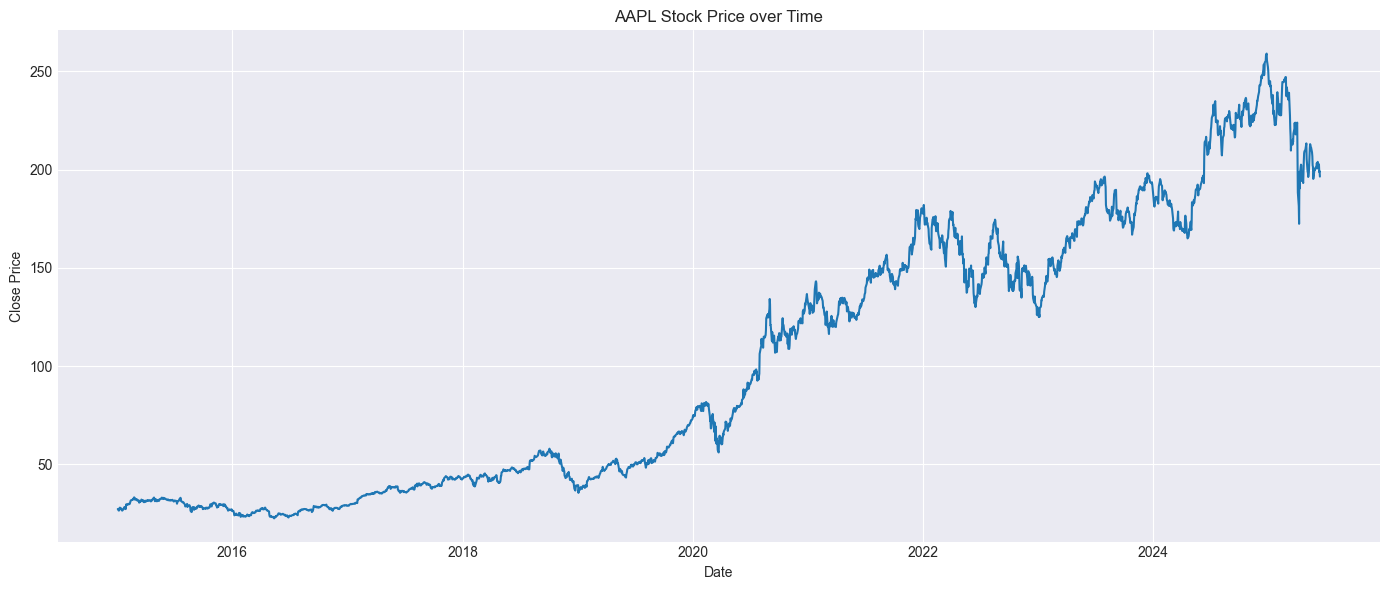

In [83]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'])
plt.title('AAPL Stock Price over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

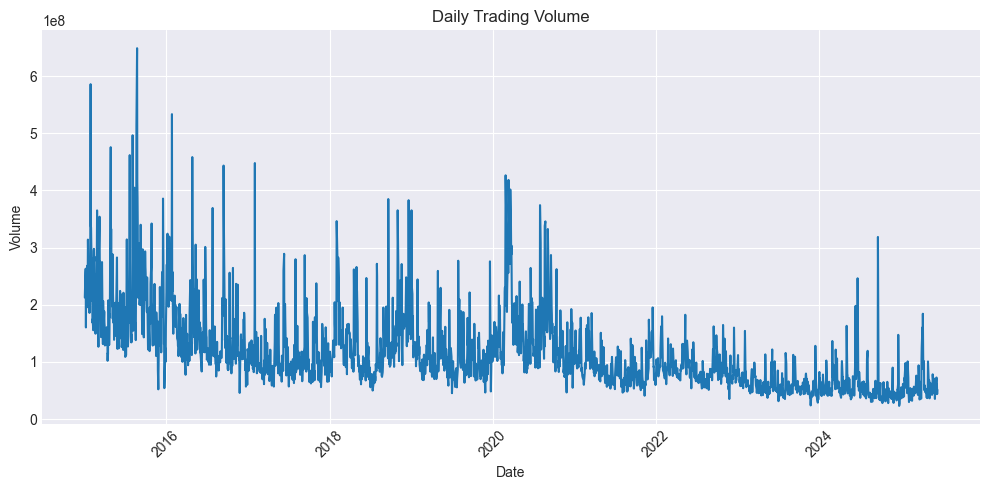

In [84]:
df["Volume"] = df["Volume"].replace(',', '', regex=True)
df["Volume"] = pd.to_numeric(df["Volume"], errors='coerce')

# Create bar graph
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Volume'], linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Daily Trading Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Close Price Distribution

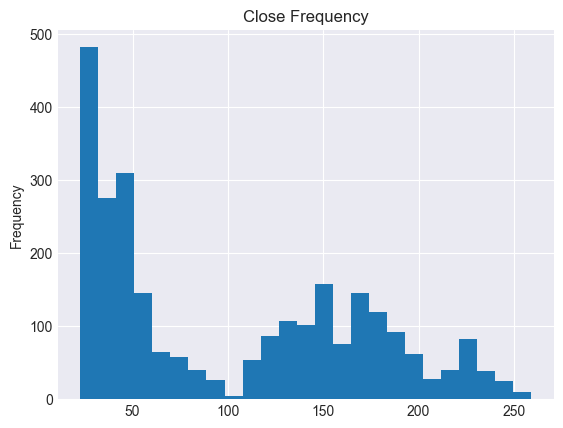

In [85]:
df['Close'].plot(kind='hist', bins=25, title='Close Frequency')
plt.show()

In [86]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [87]:
df.tail()

Open    High     Low   Close  Adj Close    Volume  dayofweek  \
Date                                                                         
2025-06-09  204.39  206.00  200.02  201.45     201.45  72862600          0   
2025-06-10  200.60  204.35  200.57  202.67     202.67  54672600          1   
2025-06-11  203.50  204.50  198.41  198.78     198.78  60989900          2   
2025-06-12  199.08  199.68  197.36  199.20     199.20  43904600          3   
2025-06-13  199.73  200.37  195.70  196.45     196.45  51447300          4   

            quarter  month  year  dayofyear  dayofmonth  weekofyear  
Date                                                                 
2025-06-09        2      6  2025        160           9          24  
2025-06-10        2      6  2025        161          10          24  
2025-06-11        2      6  2025        162          11          24  
2025-06-12        2      6  2025        163          12          24  
2025-06-13        2      6  2025        164          13          24

<Axes: >

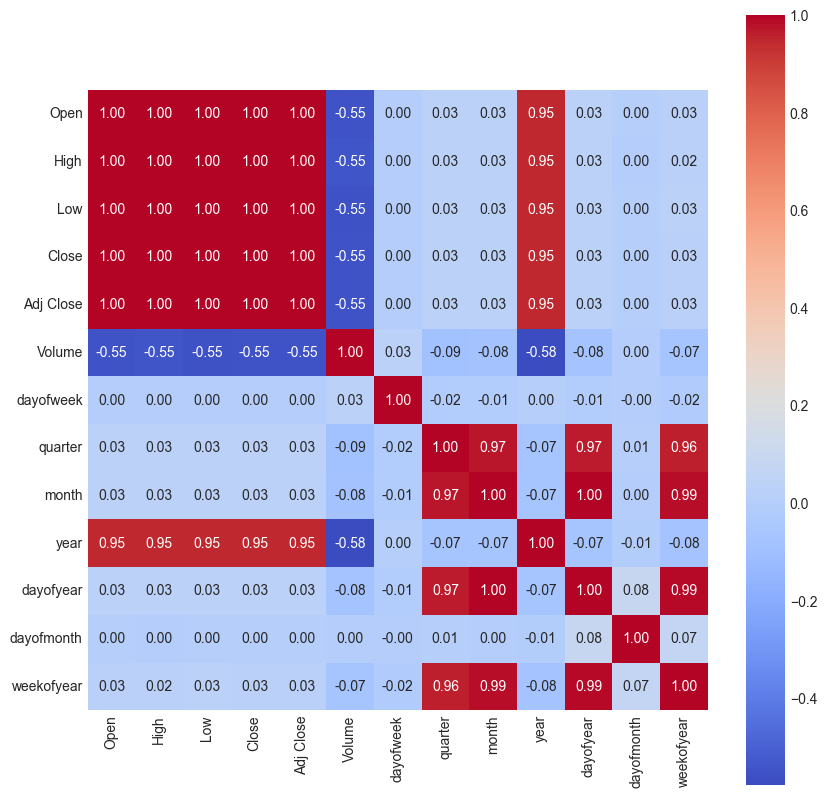

In [88]:
corrmat = df.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, annot=True, square=True, cmap='coolwarm', fmt='.2f')

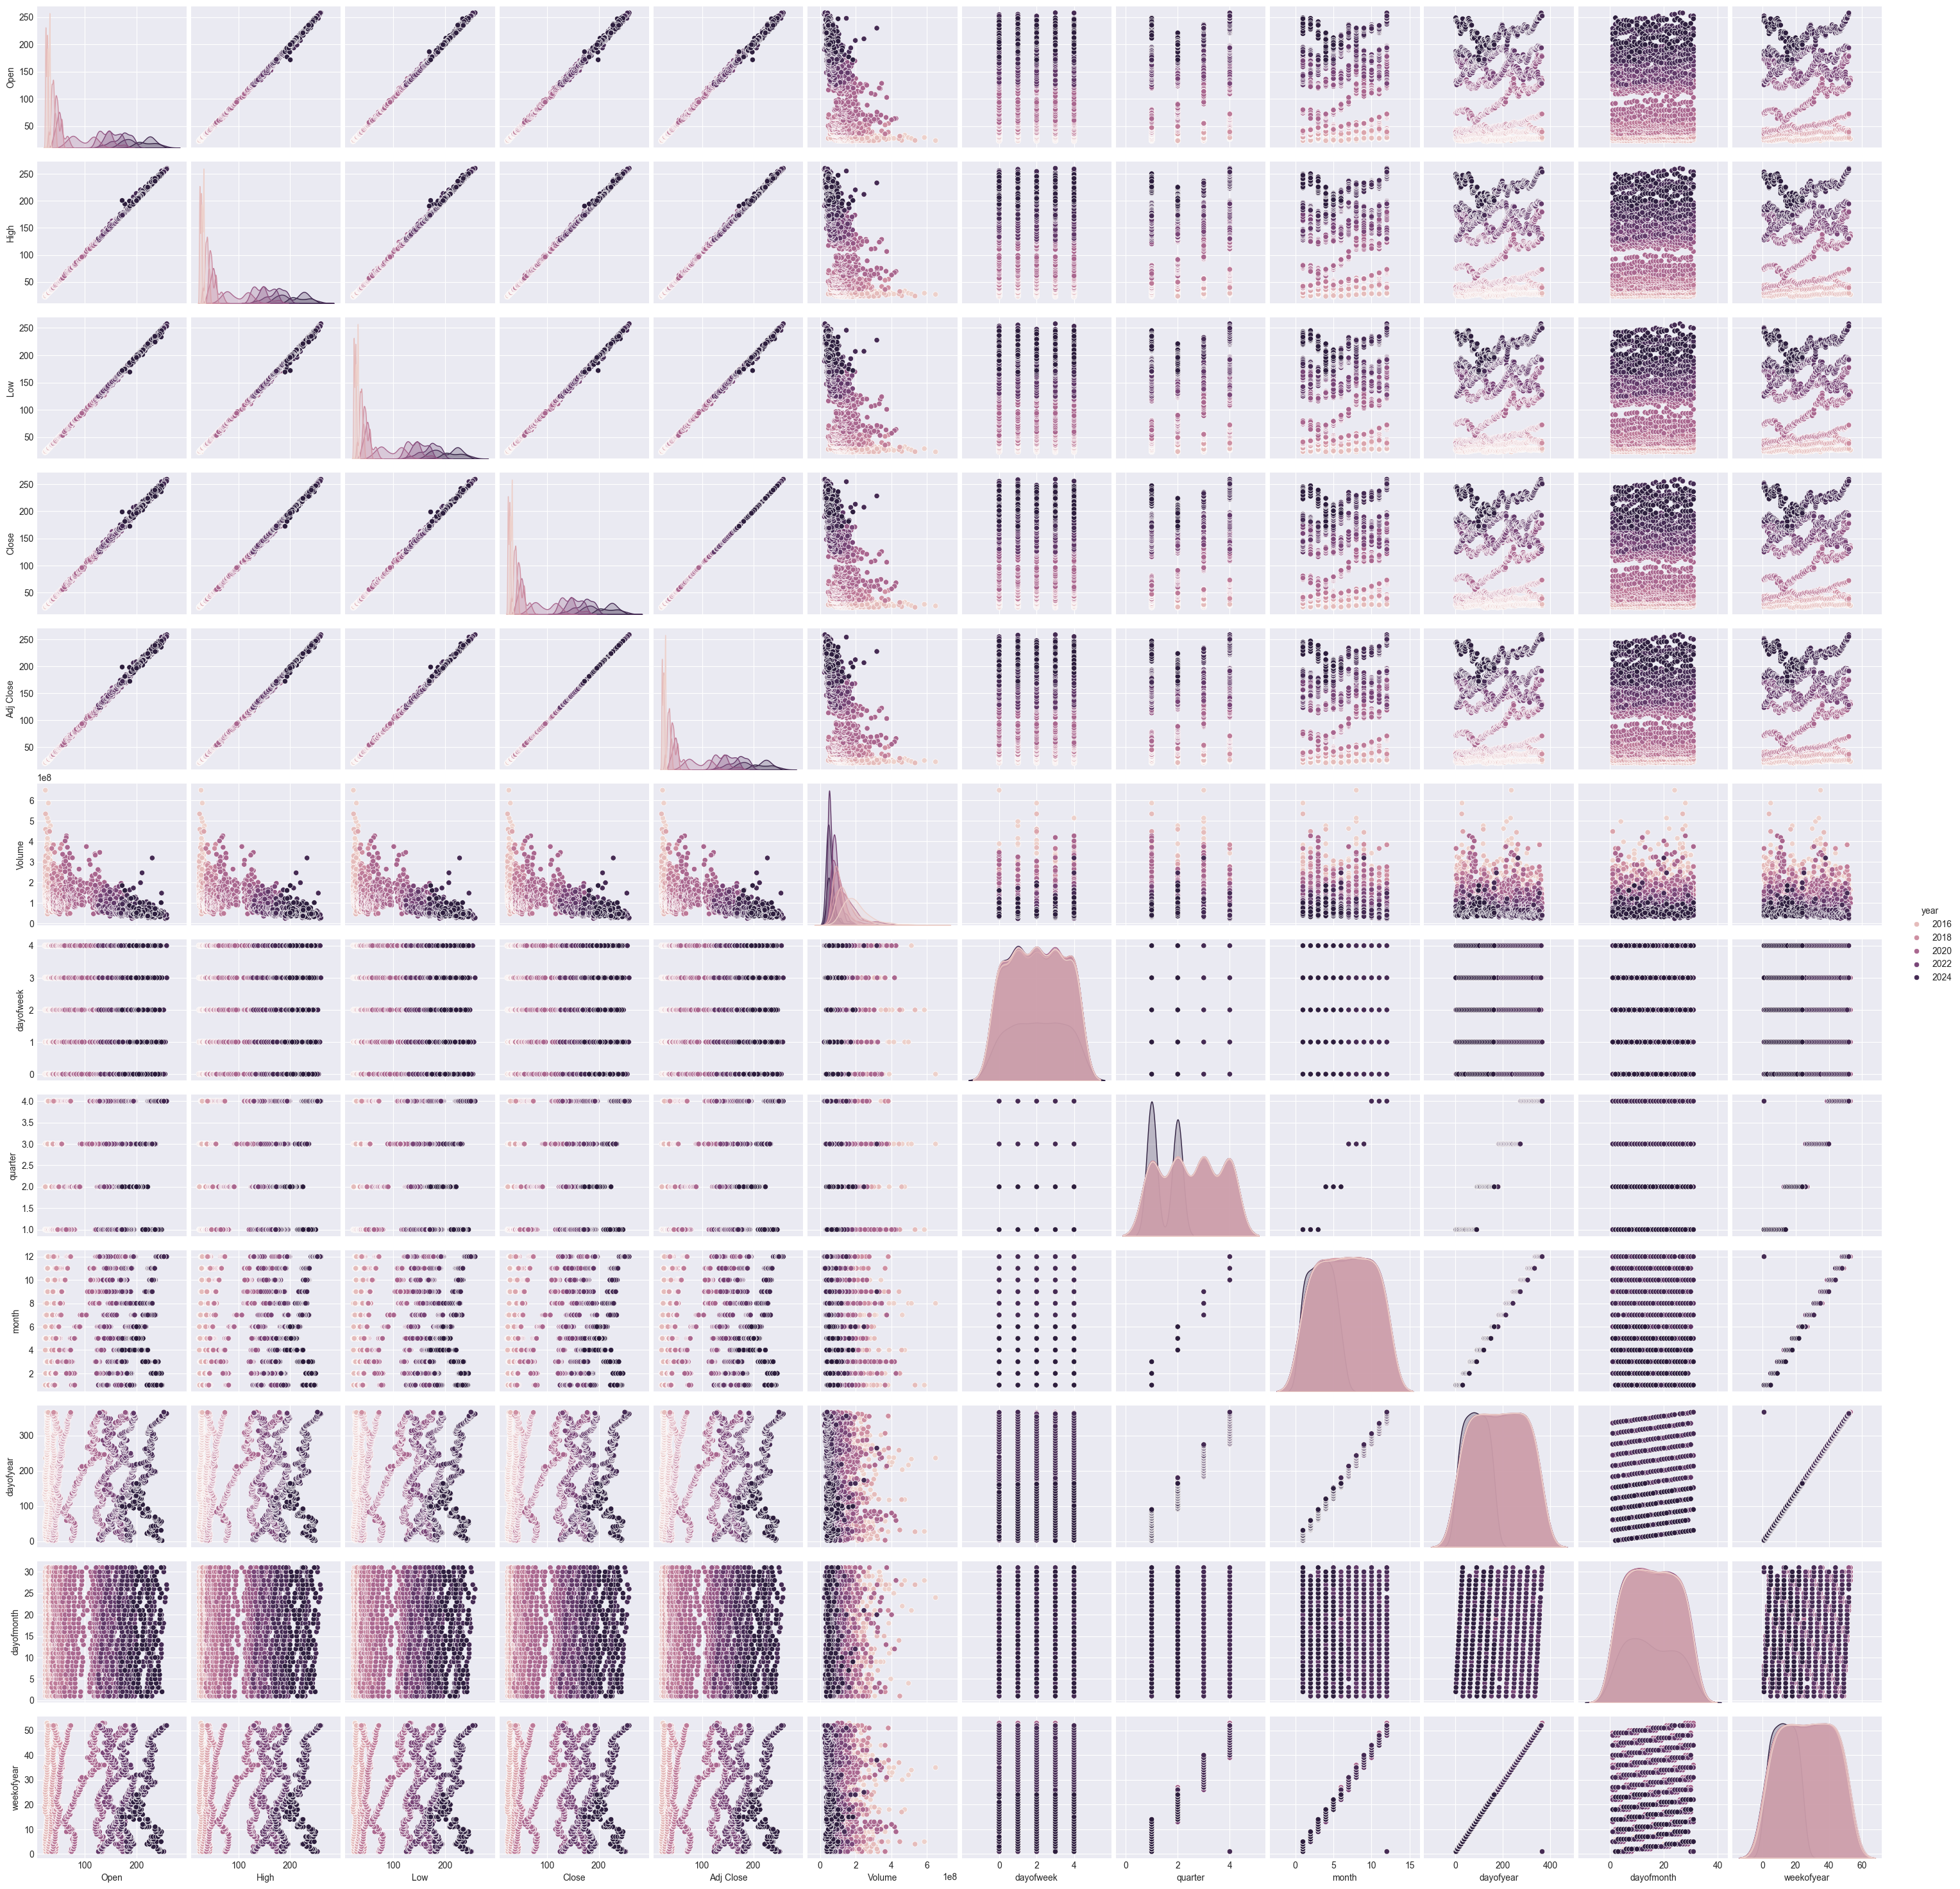

In [89]:
sns.pairplot(data=df, hue='year')
plt.show()

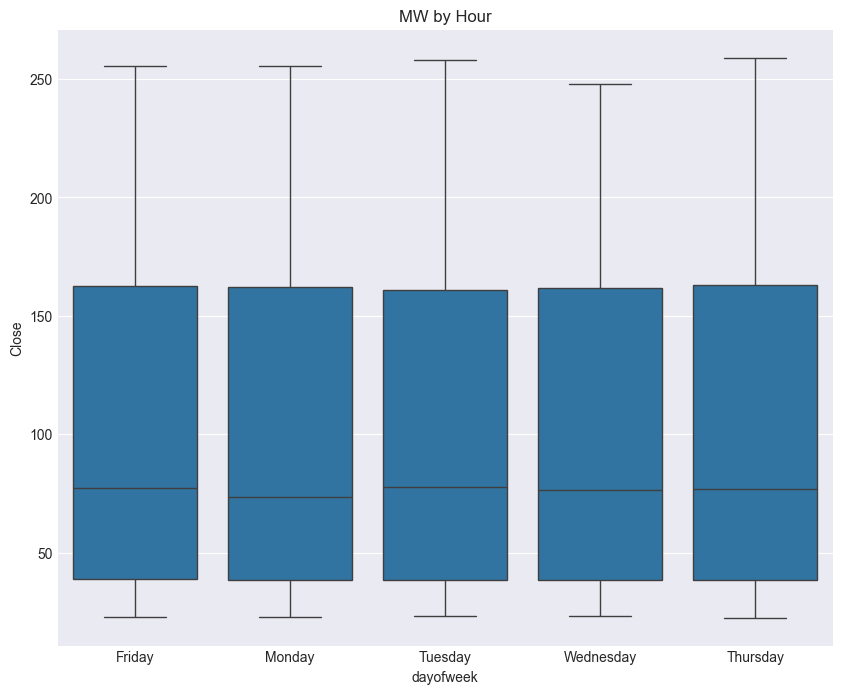

In [90]:
df['dayofweek'] = df.index.day_name()

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Close')
ax.set_title('MW by Hour')
plt.show()

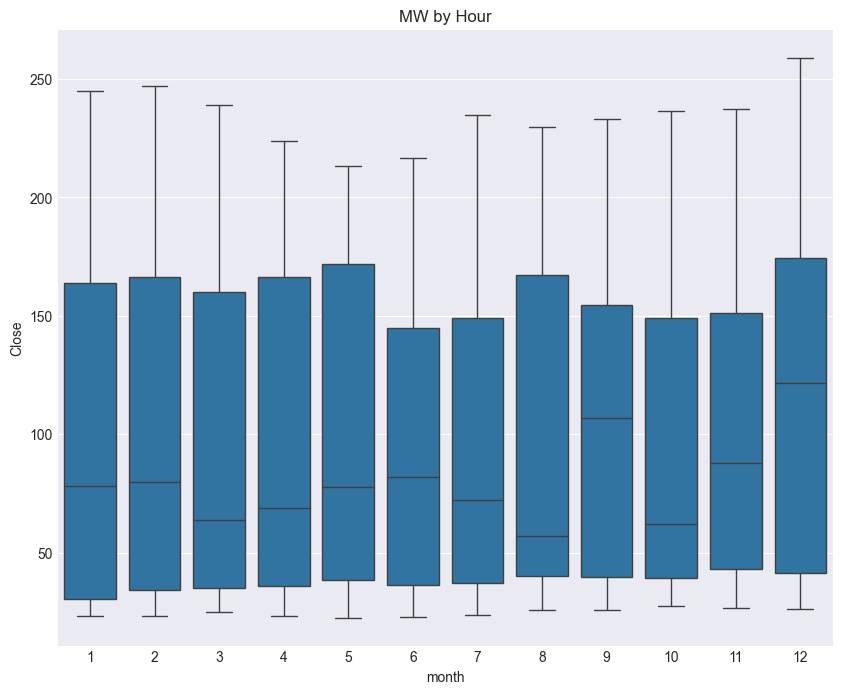

In [91]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Close')
ax.set_title('MW by Hour')
plt.show()

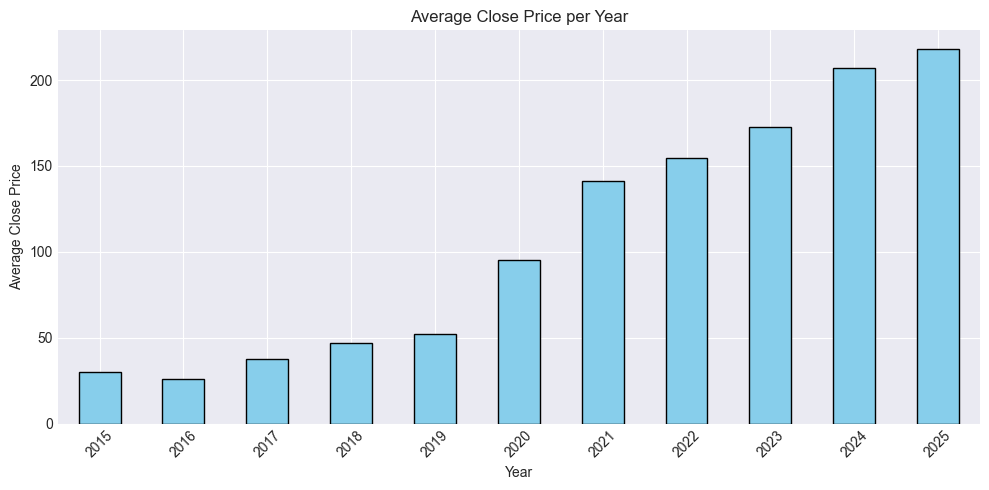

In [92]:
avg_close_per_year = df.groupby('year')['Close'].mean()
avg_close_per_year.plot(kind='bar', figsize=(10, 5), color='skyblue', edgecolor='black')
plt.title('Average Close Price per Year')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

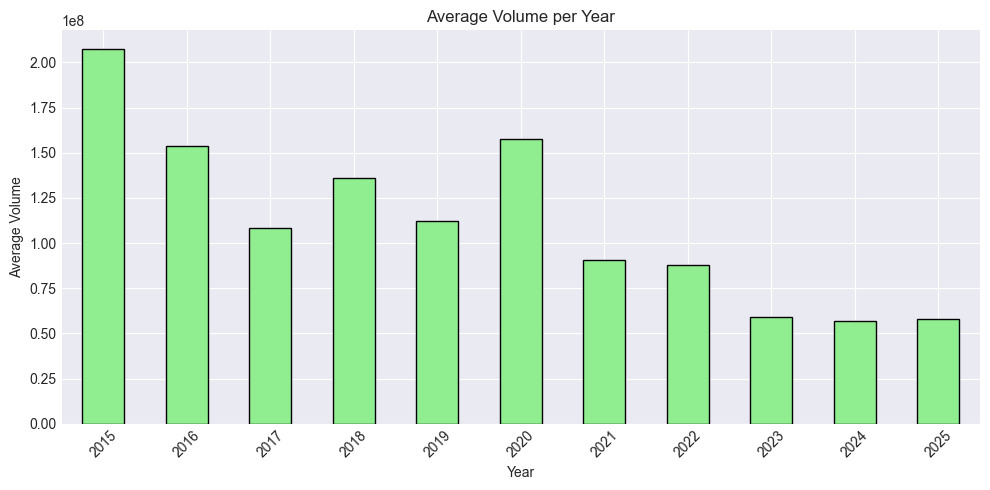

In [93]:
avg_volume_per_year = df.groupby('year')['Volume'].mean()
avg_volume_per_year.plot(kind='bar', figsize=(10, 5), color='lightgreen', edgecolor='black')
plt.title('Average Volume per Year')
plt.xlabel('Year')
plt.ylabel('Average Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## LSTM

### Scaling

In [94]:
df = df[["Close"]]
scaler = MinMaxScaler()
df["ScaledVehicles"] = scaler.fit_transform(df[["Close"]])

### Create Sequences

In [95]:
sequence_length = 50
X, y = [], []
data = df["ScaledVehicles"].values

for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length])

X = np.array(X)
y = np.array(y)

### Train/Test split

In [96]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [97]:
X_train.shape

(2062, 50, 1)

In [98]:
X_test.shape

(516, 50, 1)

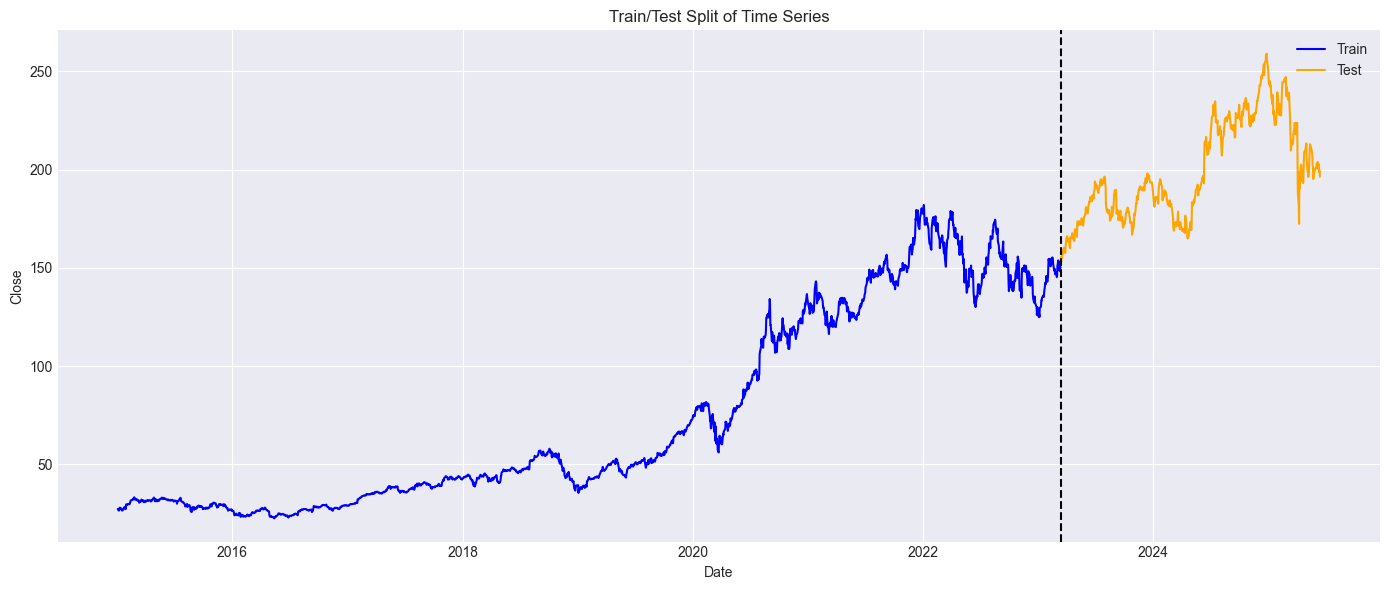

In [99]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[:split], df['Close'][:split], label='Train', color='blue')
plt.plot(df.index[split:], df['Close'][split:], label='Test', color='orange')
plt.axvline(df.index[:split].max(), color='black', ls='--')
plt.title('Train/Test Split of Time Series')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.tight_layout()
plt.show()

### First month of 2024 plot

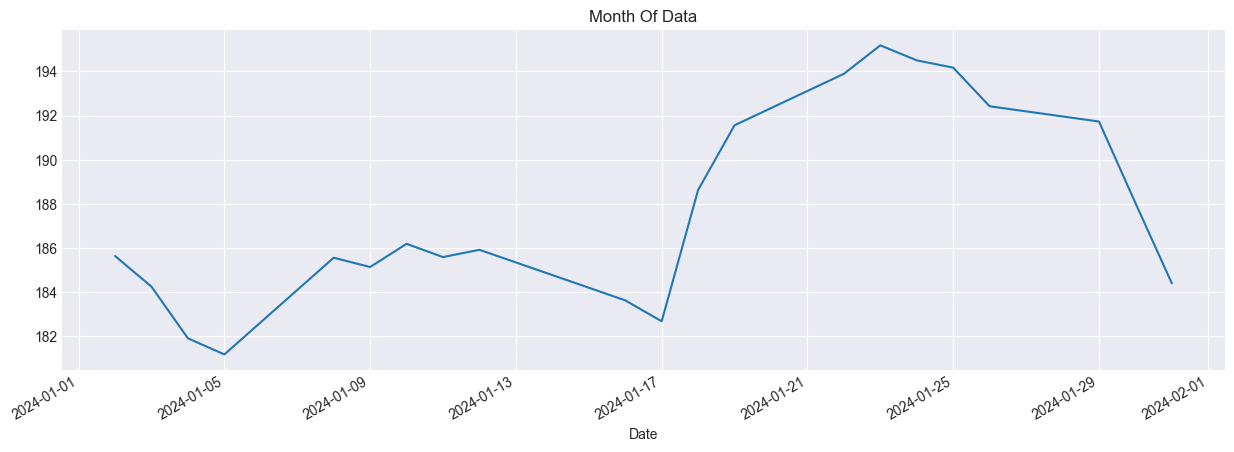

In [100]:
df['Close'].loc[(df.index > '01-01-2024') & (df.index < '02-01-2024')] \
    .plot(figsize=(15, 5), title='Month Of Data')
plt.show()

### Build LSTM Model

In [101]:
model = Sequential([
    Input(shape=(50, 1)),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

### Model Training

In [102]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0248 - val_loss: 9.1681e-04
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 7.8818e-04
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 7.3044e-04
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9027e-04 - val_loss: 9.7151e-04
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.0104e-04 - val_loss: 0.0015
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0372e-04 - val_loss: 0.0013
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.6302e-04 - val_loss: 7.6292e-04
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0446e-04 - val_loss: 0.0011
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0305e-04 - val_loss: 8.1135e-04
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.5049e-04 - val_loss: 8.1070e-04
Epoch 1

### Loss and Validation Loss for LSTM

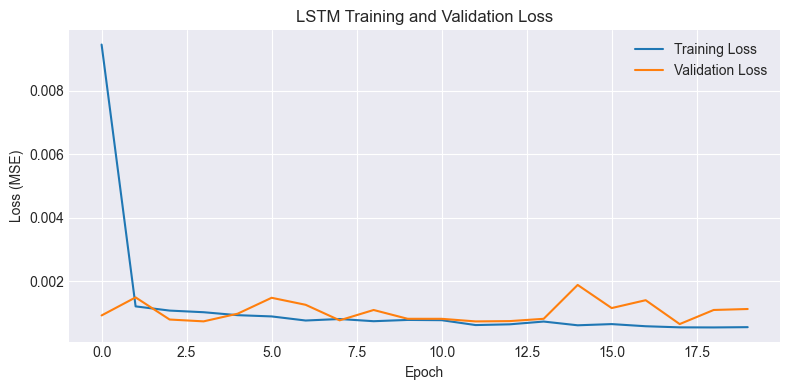

In [103]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

### Predict

In [104]:
y_pred_scaled = model.predict(X_test)
# Flatten y_pred_scaled if it has more than 2 dimensions
if y_pred_scaled.ndim == 3:
	y_pred_scaled = y_pred_scaled[:, -1, 0].reshape(-1, 1)
elif y_pred_scaled.ndim == 2 and y_pred_scaled.shape[1] != 1:
	y_pred_scaled = y_pred_scaled[:, -1].reshape(-1, 1)
elif y_pred_scaled.ndim == 2:
	y_pred_scaled = y_pred_scaled

y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


### Model Evaluation

In [105]:
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100:.2f}%")

MAE: 6.4207
MSE: 62.5854
RMSE: 7.9111
R² Score: 0.8900
MAPE: 3.11%


### Plot True vs Predicted

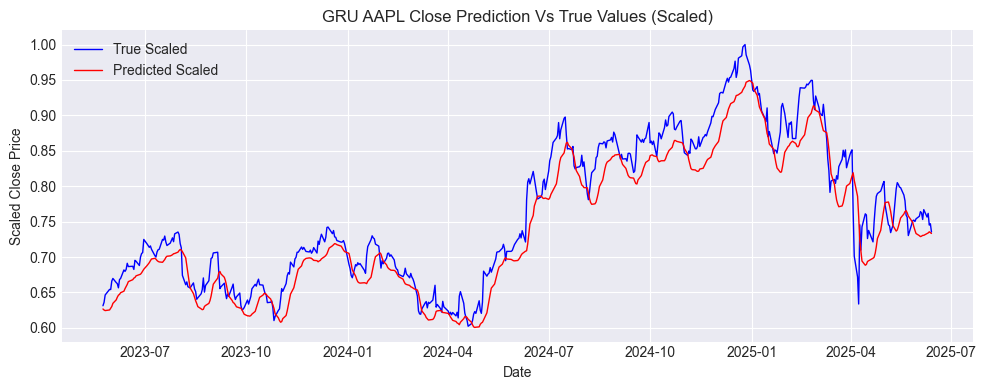

In [106]:
test_dates = df.index[split + sequence_length:]

plt.figure(figsize=(10, 4))
plt.plot(test_dates[:len(y_test)], y_test, label="True Scaled", color='blue', linewidth=1)
plt.plot(test_dates[:len(y_pred_scaled)], y_pred_scaled, label="Predicted Scaled", color='red', linewidth=1)
plt.title("GRU AAPL Close Prediction Vs True Values (Scaled)")
plt.xlabel("Date")
plt.ylabel("Scaled Close Price")
plt.legend()
plt.tight_layout()
plt.show()

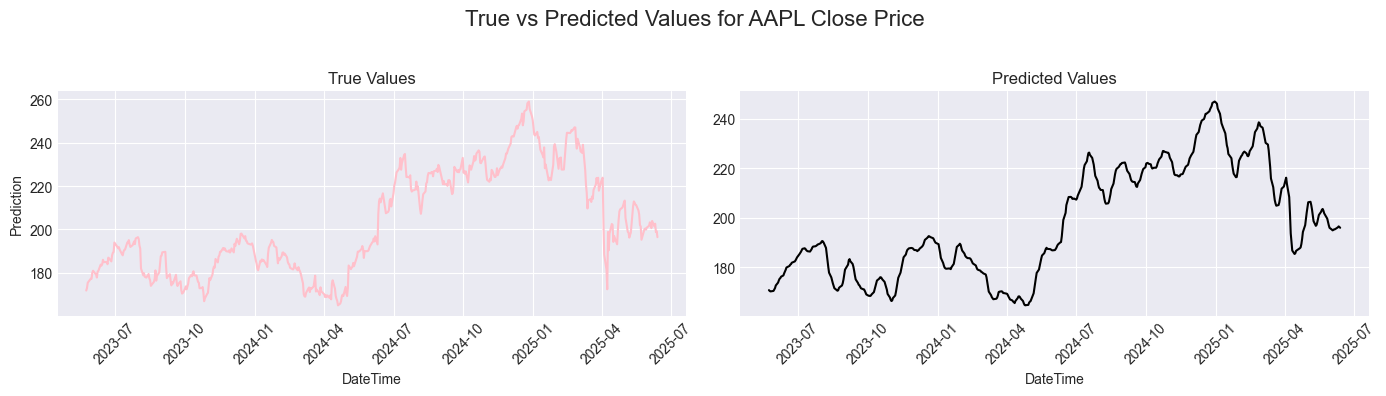

In [107]:
plt.figure(figsize=(14, 4))

# Left: True values
plt.subplot(1, 2, 1)
plt.plot(test_dates[:len(y_test_actual)], y_test_actual, color='pink', label='True')
plt.title('True Values')
plt.xticks(rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Prediction')

# Right: Predicted values
plt.subplot(1, 2, 2)
plt.plot(test_dates[:len(y_pred)], y_pred, color='black', label='Predicted')
plt.title('Predicted Values')
plt.xlabel('DateTime')
plt.xticks(rotation=45)
plt.suptitle('True vs Predicted Values for AAPL Close Price', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

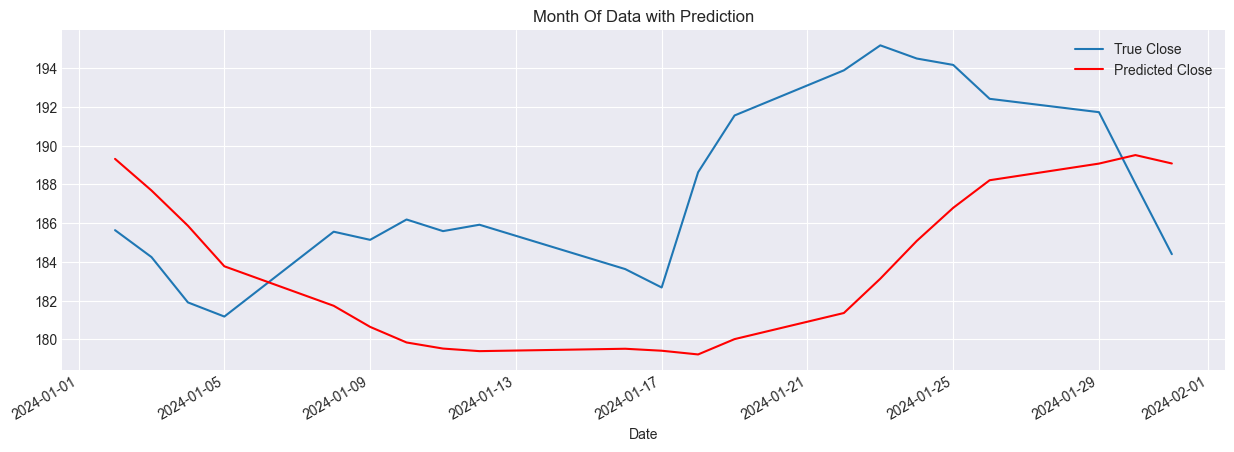

In [108]:
month_dates = test_dates[(test_dates > '2024-01-01') & (test_dates < '2024-02-01')]
month_pred_values = y_pred[(test_dates > '2024-01-01') & (test_dates < '2024-02-01')]

plt.figure(figsize=(15, 5))
df['Close'].loc[(df.index > '2024-01-01') & (df.index < '2024-02-01')].plot(label='True Close')
plt.plot(month_dates, month_pred_values, label='Predicted Close', color='red')
plt.legend()
plt.title('Month Of Data with Prediction')
plt.show()

## GRU

### Building a GRU model

In [109]:
gru_model = Sequential([
    Input(shape=(50, 1)),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

### Model Training

In [110]:
gru_history = gru_model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test)
)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0483 - val_loss: 0.0019
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 6.6517e-04
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 6.2394e-04
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 5.6855e-04
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8861e-04 - val_loss: 5.6538e-04
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 6.1853e-04
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 7.1815e-04
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.5710e-04 - val_loss: 4.2580e-04
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4478e-04 - val_loss: 4.3567e-04
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0564e-04 - val_loss: 0.0012
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0154e-04 - val_loss: 6.7183e-04
Epoch 1

### Loss and Validation Loss for GRU

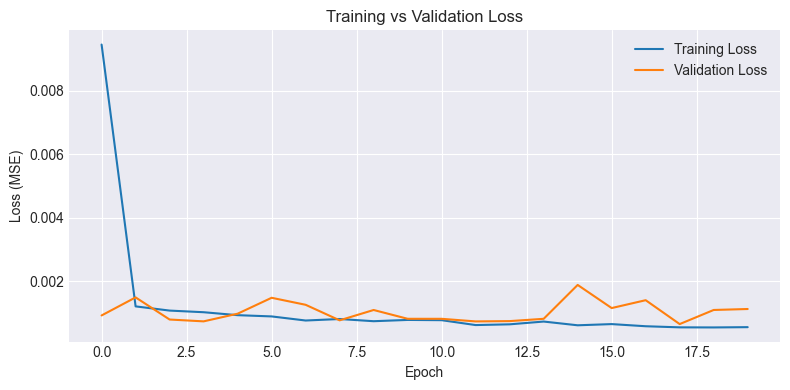

In [111]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

### Model Evaluation

In [112]:
gru_pred_scaled = gru_model.predict(X_test)
gru_pred = scaler.inverse_transform(gru_pred_scaled)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [113]:
mae = mean_absolute_error(y_test_actual, gru_pred)
mse = mean_squared_error(y_test_actual, gru_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, gru_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {np.mean(np.abs((y_test_actual - gru_pred) / y_test_actual)) * 100:.2f}%")

MAE: 5.3762
MSE: 41.5756
RMSE: 6.4479
R² Score: 0.9269
MAPE: 2.61%


### Plot True vs Predicted Values for GRU

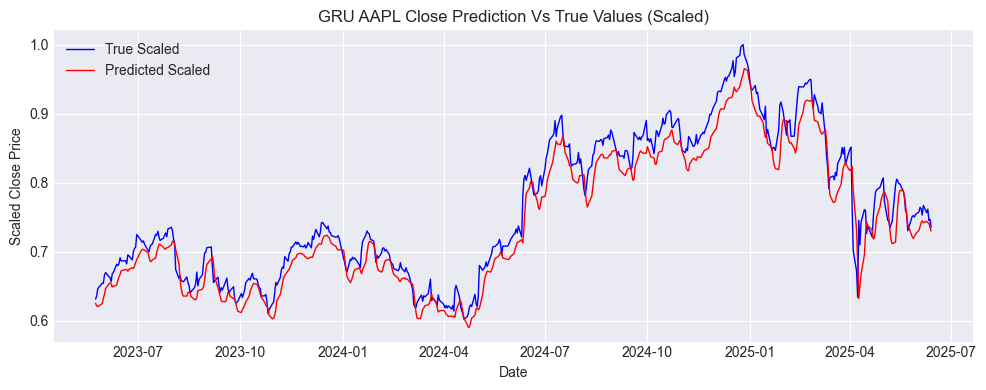

In [114]:
plt.figure(figsize=(10, 4))
plt.plot(test_dates[:len(y_test)], y_test, label="True Scaled", color='blue', linewidth=1)
plt.plot(test_dates[:len(y_pred_scaled)], gru_pred_scaled, label="Predicted Scaled", color='red', linewidth=1)
plt.title("GRU AAPL Close Prediction Vs True Values (Scaled)")
plt.xlabel("Date")
plt.ylabel("Scaled Close Price")
plt.legend()
plt.tight_layout()
plt.show()

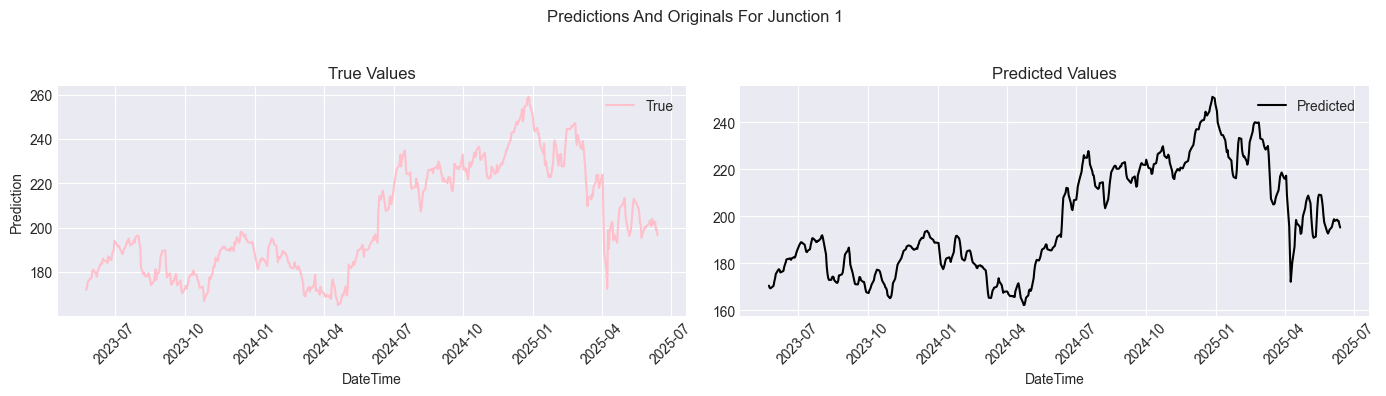

In [115]:
plt.figure(figsize=(14, 4))

# Left: True values
plt.subplot(1, 2, 1)
plt.plot(test_dates[:len(y_test_actual)], y_test_actual, color='pink', label='True')
plt.title('True Values')
plt.xticks(rotation=45)
plt.legend()
plt.xlabel('DateTime')
plt.ylabel('Prediction')

# Right: Predicted values
plt.subplot(1, 2, 2)
plt.plot(test_dates[:len(gru_pred)], gru_pred, color='black', label='Predicted')
plt.title('Predicted Values')
plt.xticks(rotation=45)
plt.legend()
plt.xlabel('DateTime')

plt.suptitle('Predictions And Originals For Junction 1')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

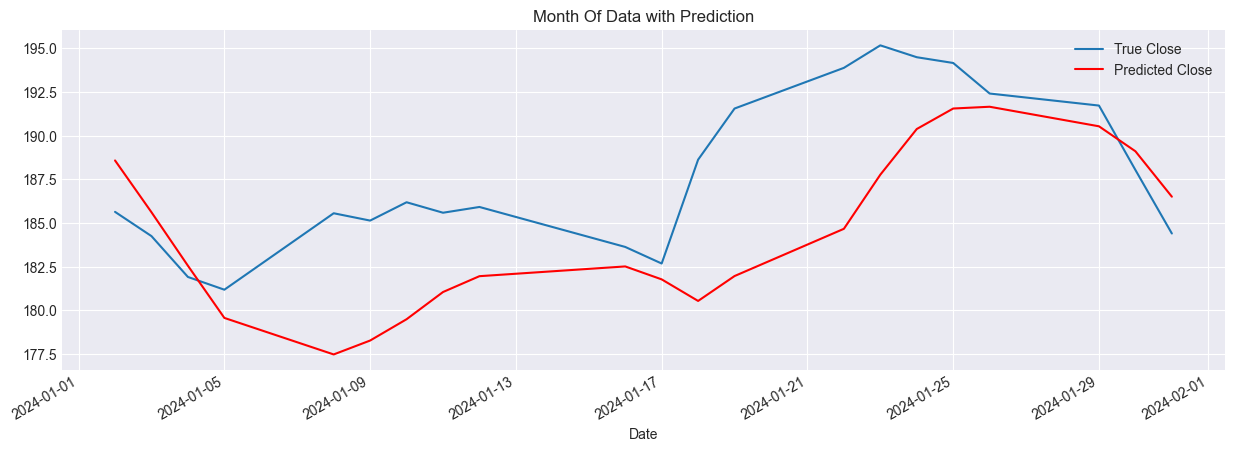

In [116]:
month_dates = test_dates[(test_dates > '2024-01-01') & (test_dates < '2024-02-01')]
month_pred_values = gru_pred[(test_dates > '2024-01-01') & (test_dates < '2024-02-01')]

plt.figure(figsize=(15, 5))
df['Close'].loc[(df.index > '2024-01-01') & (df.index < '2024-02-01')].plot(label='True Close')
plt.plot(month_dates, month_pred_values, label='Predicted Close', color='red')
plt.legend()
plt.title('Month Of Data with Prediction')
plt.show()